In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -r requirements.txt
# !pip install tensorflow==2.3
# !pip install git+https://github.com/huggingface/transformers
!pip install python_box
# !pip uninstall apex
# !pip install git+https://github.com/NVIDIA/apex

In [1]:
from box import Box
import pandas as pd
import collections
import os
from tqdm import tqdm, trange
import sys
import random
import numpy as np
import apex
from sklearn.model_selection import train_test_split
import datetime

from pathlib import Path
import torch
from transformers import BertTokenizer

from bert.modeling import BertForMultiLabelSequenceClassification
from bert.data_cls import BertDataBunch, InputExample, InputFeatures, MultiLabelTextProcessor, convert_examples_to_features
from bert.bert_cls import BertLearner
from bert.metrics import accuracy_multilabel, accuracy_thresh, fbeta, roc_auc, F1, Exact_Match_Ratio, Hamming_loss, accuracy

In [2]:
torch.cuda.empty_cache()

In [3]:
# disney_data = str('/content/drive/' + 'My Drive' + '/disney_bert_classification/sample_data/disney/')
disney_data = str('./sample_data/disney/')
disney_data

'/content/drive/My Drive/disney_bert_classification/sample_data/disney/'

In [4]:
pd.set_option('display.max_colwidth', -1)
run_start_time = datetime.datetime.today().strftime('%Y-%m-%d_%H-%M-%S')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [5]:
disney_data = "./sample_data/disney/"
finetuned_path = "./sample_data/disney/models/output/model_out_bert/pytorch_model.bin" 

# disney_data = "/content/drive/My Drive/disney_bert_classification/sample_data/disney/"
# finetuned_path = "/content/drive/My Drive/disney_bert_classification/sample_data/disney/models/output/model_out_bert/pytorch_model.bin" 

DATA_PATH = Path(disney_data + 'data/')
LABEL_PATH = Path(disney_data + 'label/')

AUG_DATA_PATH = Path(disney_data + 'data/data_augmentation/')

MODEL_PATH=Path(disney_data + 'models/')
LOG_PATH=Path(disney_data + 'logs/')
MODEL_PATH.mkdir(exist_ok=True)

model_state_dict = None

OUTPUT_PATH = MODEL_PATH/'output'
OUTPUT_PATH.mkdir(exist_ok=True)

BERT_PRETRAINED_PATH = Path(disney_data + 'bert-base-japanese-whole-word-masking/')
FINETUNED_PATH = finetuned_path #Path(OUTPUT_PATH + '/model_out_bert/pytorch_model.bin')

LOG_PATH.mkdir(exist_ok=True)


In [7]:
args = Box({
    "run_text": "multilabel disney comments with freezable layers",
    "train_size": -1,
    "val_size": -1,
    "log_path": LOG_PATH,
    "full_data_dir": DATA_PATH,
    "data_dir": DATA_PATH,
    "task_name": "disney_classification_lib",
    "no_cuda": False,
    "bert_model": BERT_PRETRAINED_PATH,
    "output_dir": OUTPUT_PATH,
    "max_seq_length": 512,
    "do_train": True,
    "do_eval": True,
    "do_lower_case": True,
    "train_batch_size": 8,
    "eval_batch_size": 16,
    "learning_rate": 5e-5,
    "num_train_epochs": 4,
    "warmup_proportion": 0.0,
    "no_cuda": False,
    "local_rank": -1,
    "seed": 42,
    "gradient_accumulation_steps": 1,
    "optimize_on_cpu": False,
    "fp16": True,
    "fp16_opt_level": "O1",
    "weight_decay": 0.0,
    "adam_epsilon": 1e-8,
    "max_grad_norm": 1.0,
    "max_steps": -1,
    "warmup_steps": 500,
    "logging_steps": 50,
    "eval_all_checkpoints": True,
    "overwrite_output_dir": True,
    "overwrite_cache": False,
    "seed": 42,
    "loss_scale": 128,
    "task_name": 'intent',
    "model_name": 'bert-base-cased',
    "model_type": 'bert'
})

In [8]:
import logging

logfile = str(LOG_PATH/'log-{}-{}.txt'.format(run_start_time, args["run_text"]))

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
    datefmt='%m/%d/%Y %H:%M:%S',
    handlers=[
        logging.FileHandler(logfile),
        logging.StreamHandler(sys.stdout)
    ])

logger = logging.getLogger()

In [10]:
logger.info(args)

11/17/2020 17:52:09 - INFO - root -   {'run_text': 'multilabel disney comments with freezable layers', 'train_size': -1, 'val_size': -1, 'log_path': PosixPath('/content/drive/My Drive/disney_bert_classification/sample_data/disney/logs'), 'full_data_dir': PosixPath('/content/drive/My Drive/disney_bert_classification/sample_data/disney/data'), 'data_dir': PosixPath('/content/drive/My Drive/disney_bert_classification/sample_data/disney/data'), 'task_name': 'intent', 'no_cuda': False, 'bert_model': PosixPath('/content/drive/My Drive/disney_bert_classification/sample_data/disney/bert-base-japanese-whole-word-masking'), 'output_dir': PosixPath('/content/drive/My Drive/disney_bert_classification/sample_data/disney/models/output'), 'max_seq_length': 512, 'do_train': True, 'do_eval': True, 'do_lower_case': True, 'train_batch_size': 8, 'eval_batch_size': 16, 'learning_rate': 5e-05, 'num_train_epochs': 4, 'warmup_proportion': 0.0, 'local_rank': -1, 'seed': 42, 'gradient_accumulation_steps': 1, 'o

In [11]:
device = torch.device('cuda')
#device = torch.device('cuda:0')
if torch.cuda.device_count() > 1:
    args.multi_gpu = True
else:
    args.multi_gpu = False

In [12]:
label_cols = ['パーク全般P', '園内全体の外観・装飾P', '園内全体の混雑状況P', '清潔感P', 'スペシャルイベント（装飾）P',
       'スペシャルイベント（その他）P', '園内環境P', '価格P', 'その他（パーク全体）P', '【アトラクション】質（面白さ）P',
       '【アトラクション】待ち時間/混雑状況P', '【アトラクション】休止・工事（リハブ・シス調）P', '【アトラクション】休止（天候要因）P',
       '【アトラクション】FPP', '【アトラクション】その他P', '【エンタ】パレード/ショー/花火(質・面白さ）P',
       '【エンタ】キャラクターグリーティング（出会い）P', '【エンタ】キャラクターグリーティング（混雑）P',
       '【エンタ】キャラクターグリーティング（その他）P', '【エンタ】休止・中止（悪天候）P', '【エンタ】休止・中止（リハブ・シス調）P',
       '【エンタ】その他P', '【フード】待ち時間/混雑状況P', '【フード】その他P', '【商品】その他P', '【レストルーム】清潔さP',
       '【レストルーム】その他P', '【キャスト】対応能力（迅速さ・正確さ）P', '【キャスト】態度・印象（笑顔・礼儀・話し方等）P',
       '【キャスト】その他P', '【その他サービス施設】その他P', 'パーク全般N', '園内全体の外観・装飾N', '園内全体の混雑状況N',
       '清潔感N', 'スペシャルイベント（装飾）N', 'スペシャルイベント（その他）N', '園内環境N', '価格N',
       'その他（パーク全体）N', '【アトラクション】質（面白さ）N', '【アトラクション】待ち時間/混雑状況N',
       '【アトラクション】休止・工事（リハブ・シス調）N', '【アトラクション】休止（天候要因）N', '【アトラクション】FPN',
       '【アトラクション】その他N', '【エンタ】パレード/ショー/花火(質・面白さ）N', '【エンタ】キャラクターグリーティング（出会い）N',
       '【エンタ】キャラクターグリーティング（混雑）N', '【エンタ】キャラクターグリーティング（その他）N',
       '【エンタ】休止・中止（悪天候）N', '【エンタ】休止・中止（リハブ・シス調）N', '【エンタ】その他N',
       '【フード】待ち時間/混雑状況N', '【フード】その他N', '【商品】その他N', '【レストルーム】清潔さN',
       '【レストルーム】その他N', '【キャスト】対応能力（迅速さ・正確さ）N', '【キャスト】態度・印象（笑顔・礼儀・話し方等）N',
       '【キャスト】その他N', '【その他サービス施設】その他N']

In [13]:
databunch = BertDataBunch(args['data_dir'], LABEL_PATH, args.model_name, train_file='disney_land_train_clean.csv', val_file='disney_land_test_clean.csv',
                          label_file='disney_land_labels.csv',
                          text_col="パーク全体FA", label_col=label_cols,
                          batch_size_per_gpu=args['train_batch_size'], max_seq_length=args['max_seq_length'], 
                          multi_gpu=args.multi_gpu, multi_label=True, model_type=args.model_type)

11/17/2020 17:52:10 - INFO - root -   Loading features from cached file /content/drive/My Drive/disney_bert_classification/sample_data/disney/data/cache/cached_bert_train_multi_label_512_disney_land_train_clean.csv
11/17/2020 17:52:18 - INFO - root -   Loading features from cached file /content/drive/My Drive/disney_bert_classification/sample_data/disney/data/cache/cached_bert_dev_multi_label_512_disney_land_test_clean.csv


In [14]:
databunch.train_dl.dataset[0][3]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [15]:
num_labels = len(databunch.labels)
num_labels

62

In [17]:
# metrics 
metrics = []
metrics.append({'name': 'accuracy_thresh', 'function': accuracy_thresh})
metrics.append({'name': 'roc_auc', 'function': roc_auc})
metrics.append({'name': 'fbeta', 'function': fbeta})
metrics.append({'name': 'f1', 'function': F1})

# Training

In [18]:
def calculate_pos_weights(class_counts):
    pos_weights = np.ones_like(class_counts)
    neg_counts = [len(data)-pos_count for pos_count in class_counts]
    for cdx, pos_count, neg_count in enumerate(zip(class_counts,  neg_counts)):
      pos_weights[cdx] = neg_count / (pos_count + 1e-5)

    return torch.as_tensor(pos_weights, dtype=torch.float)
pos_w = pos_weight = torch.ones([62])

learner = BertLearner.from_pretrained_model(databunch, args.model_name, metrics=metrics, 
                                            device=device, logger=logger, output_dir=args.output_dir, 
                                            finetuned_wgts_path=FINETUNED_PATH, warmup_steps=args.warmup_steps,
                                            multi_gpu=args.multi_gpu, is_fp16=args.fp16, 
                                            multi_label=True, logging_steps=0)


11/17/2020 17:52:39 - INFO - filelock -   Lock 139936150979360 acquired on /root/.cache/torch/transformers/092cc582560fc3833e556b3f833695c26343cb54b7e88cd02d40821462a74999.1f48cab6c959fc6c360d22bea39d06959e90f5b002e77e836d2da45464875cda.lock



11/17/2020 17:52:46 - INFO - filelock -   Lock 139936150979360 released on /root/.cache/torch/transformers/092cc582560fc3833e556b3f833695c26343cb54b7e88cd02d40821462a74999.1f48cab6c959fc6c360d22bea39d06959e90f5b002e77e836d2da45464875cda.lock


In [ ]:
#%%time

learner.fit(args.num_train_epochs, args.learning_rate, validate=True)

In [19]:
%%time

learner.validate()

11/17/2020 17:52:57 - INFO - root -   Running evaluation
11/17/2020 17:52:57 - INFO - root -     Num examples = 4695
11/17/2020 17:52:57 - INFO - root -     Batch size = 16


CPU times: user 1min 24s, sys: 1min 8s, total: 2min 33s
Wall time: 2min 33s


{'accuracy_thresh': 0.9695489406585693,
 'f1': 0.0032912418246269226,
 'fbeta': 0.0025408435612916946,
 'loss': 0.1144032043461897,
 'roc_auc': 0.8199122630878748}

In [ ]:
learner.save_model()

# Prediction

In [20]:
from bert.modeling import BertForMultiLabelSequenceClassification
from bert.predictor import BertClassificationPredictor
from bert.data_cls import BertDataBunch, InputExample, InputFeatures, MultiLabelTextProcessor, convert_examples_to_features
from bert.bert_cls import BertLearner
from bert.metrics import accuracy_multilabel, accuracy_thresh, fbeta, roc_auc

In [21]:
predictor = BertClassificationPredictor(str(args.output_dir/'model_out_bert'), 
                                        LABEL_PATH, 
                                        multi_label=True, 
                                        model_type='bert', 
                                        do_lower_case=False)

In [22]:
%%time

output = predictor.predict_batch(list(pd.read_csv(disney_data +'data/disney_land_test_clean.csv')['パーク全体FA'].values))

11/17/2020 17:55:38 - INFO - root -   Writing example 0 of 4695


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


CPU times: user 1min 30s, sys: 1min 18s, total: 2min 48s
Wall time: 2min 49s


In [23]:
output[0]

[('パーク全般P', 0.19006964564323425),
 ('【エンタ】その他P', 0.09906215965747833),
 ('スペシャルイベント（その他）P', 0.08785949647426605),
 ('園内全体の混雑状況N', 0.08340363949537277),
 ('【アトラクション】その他P', 0.08212485164403915),
 ('園内全体の混雑状況P', 0.06378857791423798),
 ('その他（パーク全体）P', 0.05851072818040848),
 ('【アトラクション】待ち時間/混雑状況P', 0.0569920688867569),
 ('【エンタ】その他N', 0.04661086946725845),
 ('その他（パーク全体）N', 0.04638911038637161),
 ('【キャスト】態度・印象（笑顔・礼儀・話し方等）P', 0.043884485960006714),
 ('スペシャルイベント（その他）N', 0.04041384160518646),
 ('園内環境N', 0.03915853425860405),
 ('【アトラクション】休止・工事（リハブ・シス調）N', 0.03266046196222305),
 ('【エンタ】パレード/ショー/花火(質・面白さ）P', 0.030739229172468185),
 ('【アトラクション】待ち時間/混雑状況N', 0.029610294848680496),
 ('【フード】その他N', 0.028045058250427246),
 ('【フード】その他P', 0.027066532522439957),
 ('【アトラクション】その他N', 0.026907147839665413),
 ('【エンタ】休止・中止（悪天候）N', 0.02400054596364498),
 ('【キャスト】その他P', 0.022036630660295486),
 ('【アトラクション】FPN', 0.020469186827540398),
 ('【アトラクション】FPP', 0.019590288400650024),
 ('【商品】その他N', 0.01855555735528469),
 ('【フード

In [24]:
df_pred_bert = pd.DataFrame([{item[0]: item[1] for item in pred} for pred in output])
# df_pred_bert.to_csv(disney_data+'data/output_bert_sorted.csv')

In [25]:
df_pred_bert.head()

,パーク全般P,【エンタ】その他P,スペシャルイベント（その他）P,園内全体の混雑状況N,【アトラクション】その他P,園内全体の混雑状況P,その他（パーク全体）P,【アトラクション】待ち時間/混雑状況P,【エンタ】その他N,その他（パーク全体）N,【キャスト】態度・印象（笑顔・礼儀・話し方等）P,スペシャルイベント（その他）N,園内環境N,【アトラクション】休止・工事（リハブ・シス調）N,【エンタ】パレード/ショー/花火(質・面白さ）P,【アトラクション】待ち時間/混雑状況N,【フード】その他N,【フード】その他P,【アトラクション】その他N,【エンタ】休止・中止（悪天候）N,【キャスト】その他P,【アトラクション】FPN,【アトラクション】FPP,【商品】その他N,【フード】待ち時間/混雑状況N,【その他サービス施設】その他N,【商品】その他P,【エンタ】キャラクターグリーティング（出会い）P,【エンタ】キャラクターグリーティング（その他）P,【アトラクション】質（面白さ）P,【キャスト】その他N,【キャスト】態度・印象（笑顔・礼儀・話し方等）N,【レストルーム】その他N,スペシャルイベント（装飾）P,【エンタ】キャラクターグリーティング（その他）N,【エンタ】キャラクターグリーティング（出会い）N,価格N,【キャスト】対応能力（迅速さ・正確さ）N,【キャスト】対応能力（迅速さ・正確さ）P,【フード】待ち時間/混雑状況P,園内環境P,【エンタ】休止・中止（悪天候）P,清潔感P,園内全体の外観・装飾P,【アトラクション】質（面白さ）N,【エンタ】パレード/ショー/花火(質・面白さ）N,パーク全般N,【その他サービス施設】その他P,【エンタ】休止・中止（リハブ・シス調）N,【レストルーム】その他P,清潔感N,スペシャルイベント（装飾）N,【アトラクション】休止（天候要因）N,【エンタ】キャラクターグリーティング（混雑）N,【レストルーム】清潔さP,【レストルーム】清潔さN,価格P,【エンタ】キャラクターグリーティング（混雑）P,園内全体の外観・装飾N,【アトラクション】休止・工事（リハブ・シス調）P,【アトラクション】休止（天候要因）P,【エンタ】休止・中止（リハブ・シス調）P
0,0.190070,0.099062,0.087859,0.083404,0.082125,0.063789,0.058511,0.056992,0.046611,0.046389,0.043884,0.040414,0.039159,0.032660,0.030739,0.029610,0.028045,0.027067,0.026907,0.024001,0.022037,0.020469,0.019590,0.018556,0.015939,0.015599,0.015465,0.015137,0.015051,0.013968,0.013403,0.012175,0.011864,0.011295,0.011013,0.009985,0.009599,0.008625,0.007128,0.007040,0.006218,0.006043,0.005452,0.005073,0.004861,0.004449,0.004140,0.003861,0.003675,0.003519,0.003477,0.003073,0.002988,0.002814,0.002435,0.001945,0.001628,0.001625,0.001582,0.001510,0.001339,0.000943
1,0.220959,0.114045,0.117921,0.090220,0.097038,0.074531,0.079884,0.090492,0.070108,0.082223,0.479228,0.067006,0.049975,0.050163,0.072159,0.044087,0.075930,0.061436,0.060704,0.027325,0.175976,0.032904,0.024084,0.039414,0.043370,0.026835,0.037307,0.030946,0.027943,0.038645,0.093462,0.093309,0.026533,0.031698,0.023592,0.013867,0.024453,0.042586,0.025267,0.017676,0.014920,0.009547,0.015362,0.017325,0.010942,0.014725,0.009573,0.017406,0.008459,0.006956,0.012056,0.007397,0.008849,0.007525,0.005351,0.006333,0.004215,0.005859,0.005699,0.004304,0.004580,0.002812
2,0.213619,0.103433,0.115875,0.090010,0.094542,0.071581,0.076853,0.087402,0.063925,0.076220,0.459588,0.062164,0.047195,0.045104,0.066248,0.040494,0.067933,0.055720,0.055600,0.025442,0.167781,0.029689,0.022460,0.035028,0.039394,0.023829,0.034066,0.027706,0.026304,0.034732,0.080754,0.078565,0.024364,0.028521,0.021505,0.012703,0.022093,0.035973,0.021937,0.016057,0.013793,0.008797,0.013760,0.015425,0.009621,0.013808,0.008650,0.015445,0.007576,0.006128,0.010719,0.006681,0.007971,0.006932,0.004861,0.005764,0.003851,0.005207,0.005002,0.003865,0.003921,0.002565
3,0.194316,0.103658,0.101719,0.077420,0.084256,0.069514,0.058836,0.072001,0.044270,0.050118,0.076526,0.039899,0.036010,0.031830,0.034659,0.030890,0.031987,0.029891,0.030068,0.023329,0.030197,0.020119,0.019072,0.020768,0.017982,0.016096,0.016381,0.017237,0.017320,0.015733,0.019111,0.015734,0.011841,0.013359,0.012215,0.010307,0.009596,0.009832,0.008375,0.006947,0.006182,0.005625,0.005807,0.006136,0.005226,0.005119,0.004460,0.004328,0.003425,0.003543,0.003746,0.003329,0.002999,0.003194,0.002487,0.002125,0.001749,0.001772,0.001878,0.001689,0.001524,0.000943
4,0.189595,0.090183,0.096737,0.069854,0.074418,0.057202,0.051899,0.053896,0.041247,0.044891,0.065163,0.036012,0.031566,0.028390,0.032250,0.027792,0.028645,0.025399,0.025384,0.020392,0.028030,0.017417,0.016371,0.017786,0.015879,0.013792,0.014618,0.014857,0.015319,0.014112,0.015977,0.013922,0.011115,0.012047,0.011335,0.008747,0.008739,0.008752,0.007415,0.006676,0.005727,0.005270,0.005131,0.005119,0.004569,0.004588,0.004118,0.003869,0.003105,0.003053,0.003542,0.003071,0.002775,0.003103,0.002291,0.001914,0.001517,0.001572,0.001645,0.001335,0.001313,0.000874


# Prediction Analysis

In [26]:
import pandas as pd
import numpy as np

# For machine learning
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer,classification_report, confusion_matrix, fbeta_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from scipy.stats import hmean
from scipy.stats.mstats import gmean

import warnings

warnings.simplefilter('ignore')

In [29]:
disney_data = "./sample_data/disney/"
# disney_data = "/content/drive/My Drive/disney_bert_classification/sample_data/disney/"
file_name = disney_data + "data/FA2013-2019.xlsx"

def load_data(file_name):

    # read sheet from excel file
    dfs = pd.read_excel(file_name, sheet_name=None)
    df_org = dfs['パ全']

    # drop null items
    df_org = df_org[df_org.notnull()]

    # remove irrelevant columns
    df_org = df_org.drop(columns=['年度', '来園月','来園日','同行形態','TDL1年以内来園回数','再来園意向','性別','年齢'])

    print('DataFrame dim:', df_org.shape, '\n')
    X = df_org['パーク全体FA']
    y = df_org.iloc[:,2:]
    return X, y

X,y=load_data(file_name)
X_train, X_test, y_train, y_test = train_test_split(X, y)

11/17/2020 17:59:46 - INFO - numexpr.utils -   NumExpr defaulting to 2 threads.
DataFrame dim: (25768, 64) 



In [30]:
THRESHOLD: float = 0.5  # keep in range [0.0, 1.0] 

def thred_cmp(x):
  if x >= THRESHOLD:
    return 1
  else:
    return 0

# df_pred_xlnet = pd.read_csv(disney_data+'data/output_xlnet.csv')
# df_pred_bert = pd.read_csv(disney_data+'data/output_bert_sorted.csv')

# transform to dataframe
df_pred_bert = pd.DataFrame([{item[0]: item[1] for item in pred} for pred in output])

# reorder columns
df_pred_bert = df_pred_bert[label_cols]

# covert to 0 or 1 based on THRESHOLD
df_pred_bert_trans = df_pred_bert.applymap(thred_cmp)
print(df_pred_bert_trans.shape)
df_pred_bert_trans.head(1)

(4695, 62)


,パーク全般P,園内全体の外観・装飾P,園内全体の混雑状況P,清潔感P,スペシャルイベント（装飾）P,スペシャルイベント（その他）P,園内環境P,価格P,その他（パーク全体）P,【アトラクション】質（面白さ）P,【アトラクション】待ち時間/混雑状況P,【アトラクション】休止・工事（リハブ・シス調）P,【アトラクション】休止（天候要因）P,【アトラクション】FPP,【アトラクション】その他P,【エンタ】パレード/ショー/花火(質・面白さ）P,【エンタ】キャラクターグリーティング（出会い）P,【エンタ】キャラクターグリーティング（混雑）P,【エンタ】キャラクターグリーティング（その他）P,【エンタ】休止・中止（悪天候）P,【エンタ】休止・中止（リハブ・シス調）P,【エンタ】その他P,【フード】待ち時間/混雑状況P,【フード】その他P,【商品】その他P,【レストルーム】清潔さP,【レストルーム】その他P,【キャスト】対応能力（迅速さ・正確さ）P,【キャスト】態度・印象（笑顔・礼儀・話し方等）P,【キャスト】その他P,【その他サービス施設】その他P,パーク全般N,園内全体の外観・装飾N,園内全体の混雑状況N,清潔感N,スペシャルイベント（装飾）N,スペシャルイベント（その他）N,園内環境N,価格N,その他（パーク全体）N,【アトラクション】質（面白さ）N,【アトラクション】待ち時間/混雑状況N,【アトラクション】休止・工事（リハブ・シス調）N,【アトラクション】休止（天候要因）N,【アトラクション】FPN,【アトラクション】その他N,【エンタ】パレード/ショー/花火(質・面白さ）N,【エンタ】キャラクターグリーティング（出会い）N,【エンタ】キャラクターグリーティング（混雑）N,【エンタ】キャラクターグリーティング（その他）N,【エンタ】休止・中止（悪天候）N,【エンタ】休止・中止（リハブ・シス調）N,【エンタ】その他N,【フード】待ち時間/混雑状況N,【フード】その他N,【商品】その他N,【レストルーム】清潔さN,【レストルーム】その他N,【キャスト】対応能力（迅速さ・正確さ）N,【キャスト】態度・印象（笑顔・礼儀・話し方等）N,【キャスト】その他N,【その他サービス施設】その他N
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
df_test = pd.read_csv(disney_data+'data/disney_land_test_clean.csv')
print("length of pred output:",len(output))
print("shape of test:", df_test.shape) 
print("shape of pred:",df_pred_bert.shape)

# drop 'パーク全体FA'
df_test_ = df_test.drop('パーク全体FA',axis=1)

print(df_test_.shape)
df_test_.head(1)

length of pred output: 4695
shape of test: (4695, 63)
shape of pred: (4695, 62)
(4695, 62)


,パーク全般P,園内全体の外観・装飾P,園内全体の混雑状況P,清潔感P,スペシャルイベント（装飾）P,スペシャルイベント（その他）P,園内環境P,価格P,その他（パーク全体）P,【アトラクション】質（面白さ）P,【アトラクション】待ち時間/混雑状況P,【アトラクション】休止・工事（リハブ・シス調）P,【アトラクション】休止（天候要因）P,【アトラクション】FPP,【アトラクション】その他P,【エンタ】パレード/ショー/花火(質・面白さ）P,【エンタ】キャラクターグリーティング（出会い）P,【エンタ】キャラクターグリーティング（混雑）P,【エンタ】キャラクターグリーティング（その他）P,【エンタ】休止・中止（悪天候）P,【エンタ】休止・中止（リハブ・シス調）P,【エンタ】その他P,【フード】待ち時間/混雑状況P,【フード】その他P,【商品】その他P,【レストルーム】清潔さP,【レストルーム】その他P,【キャスト】対応能力（迅速さ・正確さ）P,【キャスト】態度・印象（笑顔・礼儀・話し方等）P,【キャスト】その他P,【その他サービス施設】その他P,パーク全般N,園内全体の外観・装飾N,園内全体の混雑状況N,清潔感N,スペシャルイベント（装飾）N,スペシャルイベント（その他）N,園内環境N,価格N,その他（パーク全体）N,【アトラクション】質（面白さ）N,【アトラクション】待ち時間/混雑状況N,【アトラクション】休止・工事（リハブ・シス調）N,【アトラクション】休止（天候要因）N,【アトラクション】FPN,【アトラクション】その他N,【エンタ】パレード/ショー/花火(質・面白さ）N,【エンタ】キャラクターグリーティング（出会い）N,【エンタ】キャラクターグリーティング（混雑）N,【エンタ】キャラクターグリーティング（その他）N,【エンタ】休止・中止（悪天候）N,【エンタ】休止・中止（リハブ・シス調）N,【エンタ】その他N,【フード】待ち時間/混雑状況N,【フード】その他N,【商品】その他N,【レストルーム】清潔さN,【レストルーム】その他N,【キャスト】対応能力（迅速さ・正確さ）N,【キャスト】態度・印象（笑顔・礼儀・話し方等）N,【キャスト】その他N,【その他サービス施設】その他N
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [32]:
print(type(df_pred_bert_trans.values))

#Y_train = y_train
Y_test = df_test_
Y_pred = df_pred_bert_trans.values

# Calculate the accuracy for each of them.
for i in range(len(Y_test.columns)):
    print('Category: {} '.format(Y_test.columns[i]))
    print(classification_report(Y_test.iloc[:, i].values, Y_pred[:, i]))
    print('Accuracy {}\n\n'.format(accuracy_score(Y_test.iloc[:, i].values, Y_pred[:, i])))
    print('F1 {}\n\n'.format(f1_score(Y_test.iloc[:, i].values, Y_pred[:, i],average='weighted')))

<class 'numpy.ndarray'>
Category: パーク全般P 
              precision    recall  f1-score   support

           0       0.81      1.00      0.90      3818
           1       0.00      0.00      0.00       877

    accuracy                           0.81      4695
   macro avg       0.41      0.50      0.45      4695
weighted avg       0.66      0.81      0.73      4695

Accuracy 0.8132055378061768


F1 0.7294299878642035


Category: 園内全体の外観・装飾P 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4665
           1       0.00      0.00      0.00        30

    accuracy                           0.99      4695
   macro avg       0.50      0.50      0.50      4695
weighted avg       0.99      0.99      0.99      4695

Accuracy 0.9936102236421726


F1 0.9904255754894733


Category: 園内全体の混雑状況P 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4392
           1       0.00      0.00      0.0

## Try Other Evaluation Methods

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer,classification_report, confusion_matrix, fbeta_score, multilabel_confusion_matrix, hamming_loss
from scipy.stats import hmean
from scipy.stats.mstats import gmean

def multioutput_fscore(y_true,y_pred,beta=1):
    score_list = []
    if isinstance(y_pred, pd.DataFrame) == True:
        y_pred = y_pred.values
    if isinstance(y_true, pd.DataFrame) == True:
        y_true = y_true.values
    for column in range(0,y_true.shape[1]):
        score = fbeta_score(y_true[:,column],y_pred[:,column],beta,average='weighted')
        score_list.append(score)
    f1score_numpy = np.asarray(score_list)
    f1score_numpy = f1score_numpy[f1score_numpy<1]
    f1score = gmean(f1score_numpy)
    return  f1score

def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (label-based accuracy)
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )

        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )

        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [34]:
def multioutput_fscore(y_true,y_pred,beta=1):
    score_list = []
    if isinstance(y_pred, pd.DataFrame) == True:
        y_pred = y_pred.values
    if isinstance(y_true, pd.DataFrame) == True:
        y_true = y_true.values
    for column in range(0,y_true.shape[1]):
        score = fbeta_score(y_true[:,column],y_pred[:,column],beta,average='weighted')
        score_list.append(score)
    f1score_numpy = np.asarray(score_list)
    f1score_numpy = f1score_numpy[f1score_numpy<1]
    f1score = gmean(f1score_numpy)
    return  f1score

In [35]:
y_test,y_pred = Y_test.values, Y_pred

multi_f1 = multioutput_fscore(y_test,y_pred, beta = 1)
overall_accuracy = (y_pred == y_test).mean().mean()
print('Average overall accuracy {0:.2f}% \n'.format(overall_accuracy*100))
print('F1 score (custom definition) {0:.2f}%\n'.format(multi_f1*100))

Average overall accuracy 96.95% 

F1 score (custom definition) 95.12%



In [36]:
print("precision_macro:",precision_score(y_test, y_pred, average='macro'))
print("precision_micro:",precision_score(y_test, y_pred, average='micro'))
print("precision_weighted:",precision_score(y_test, y_pred, average='weighted'))

print("recall_macro:",recall_score(y_test, y_pred, average='macro'))
print("recall_micro:",recall_score(y_test, y_pred, average='micro'))
print("recall_weighted:",recall_score(y_test, y_pred, average='weighted'))

print("accuracy:",accuracy_score(y_test, y_pred))
print("accuracy_nonormal:",accuracy_score(y_test, y_pred, normalize=False))

print("hamming_loss:",hamming_loss(y_test, y_pred))
print("hamming_score: ",(y_pred == y_test).mean())
print("avg hamming_score: ",(y_pred == y_test).mean().mean())

# Exact Match ratio:
print("Exact Match ratio: ",(np.all(y_pred == y_test, axis=1).mean()))

precision_macro: 0.004838709677419355
precision_micro: 0.3
precision_weighted: 0.016023035230352305
recall_macro: 0.0005114915092409466
recall_micro: 0.0016937669376693768
recall_weighted: 0.0016937669376693768
accuracy: 0.00021299254526091586
accuracy_nonormal: 1
hamming_loss: 0.030492287608643375
hamming_score:  0.9695077123913566
avg hamming_score:  0.9695077123913566
Exact Match ratio:  0.00021299254526091586


# multilabel confusion matrix

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [38]:
cm = multilabel_confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test,y_pred))

[[[3818    0]
  [ 877    0]]

 [[4665    0]
  [  30    0]]

 [[4392    0]
  [ 303    0]]

 [[4668    0]
  [  27    0]]

 [[4606    0]
  [  89    0]]

 [[4293    0]
  [ 402    0]]

 [[4653    0]
  [  42    0]]

 [[4691    0]
  [   4    0]]

 [[4371    0]
  [ 324    0]]

 [[4584    0]
  [ 111    0]]

 [[4372    0]
  [ 323    0]]

 [[4695    0]
  [   0    0]]

 [[4695    0]
  [   0    0]]

 [[4582    0]
  [ 113    0]]

 [[4297    0]
  [ 398    0]]

 [[4482    0]
  [ 213    0]]

 [[4624    0]
  [  71    0]]

 [[4690    0]
  [   5    0]]

 [[4601    0]
  [  94    0]]

 [[4667    0]
  [  28    0]]

 [[4695    0]
  [   0    0]]

 [[4232    0]
  [ 463    0]]

 [[4646    0]
  [  49    0]]

 [[4536    0]
  [ 159    0]]

 [[4601    0]
  [  94    0]]

 [[4691    0]
  [   4    0]]

 [[4680    0]
  [  15    0]]

 [[4627    0]
  [  68    0]]

 [[4187   35]
  [ 458   15]]

 [[4497    0]
  [ 198    0]]

 [[4662    0]
  [  33    0]]

 [[4680    0]
  [  15    0]]

 [[4692    0]
  [   3    0]]

 [[4245   

(label, matrix): パーク全般P [[3818    0]
 [ 877    0]]
(label, matrix): 園内全体の外観・装飾P [[4665    0]
 [  30    0]]
(label, matrix): 園内全体の混雑状況P [[4392    0]
 [ 303    0]]
(label, matrix): 清潔感P [[4668    0]
 [  27    0]]
(label, matrix): スペシャルイベント（装飾）P [[4606    0]
 [  89    0]]
(label, matrix): スペシャルイベント（その他）P [[4293    0]
 [ 402    0]]
(label, matrix): 園内環境P [[4653    0]
 [  42    0]]
(label, matrix): 価格P [[4691    0]
 [   4    0]]
(label, matrix): その他（パーク全体）P [[4371    0]
 [ 324    0]]
(label, matrix): 【アトラクション】質（面白さ）P [[4584    0]
 [ 111    0]]
(label, matrix): 【アトラクション】待ち時間/混雑状況P [[4372    0]
 [ 323    0]]
(label, matrix): 【アトラクション】休止・工事（リハブ・シス調）P [[4695    0]
 [   0    0]]
(label, matrix): 【アトラクション】休止（天候要因）P [[4695    0]
 [   0    0]]
(label, matrix): 【アトラクション】FPP [[4582    0]
 [ 113    0]]
(label, matrix): 【アトラクション】その他P [[4297    0]
 [ 398    0]]
(label, matrix): 【エンタ】パレード/ショー/花火(質・面白さ）P [[4482    0]
 [ 213    0]]
(label, matrix): 【エンタ】キャラクターグリーティング（出会い）P [[4624    0]
 [  71    0]]
(label

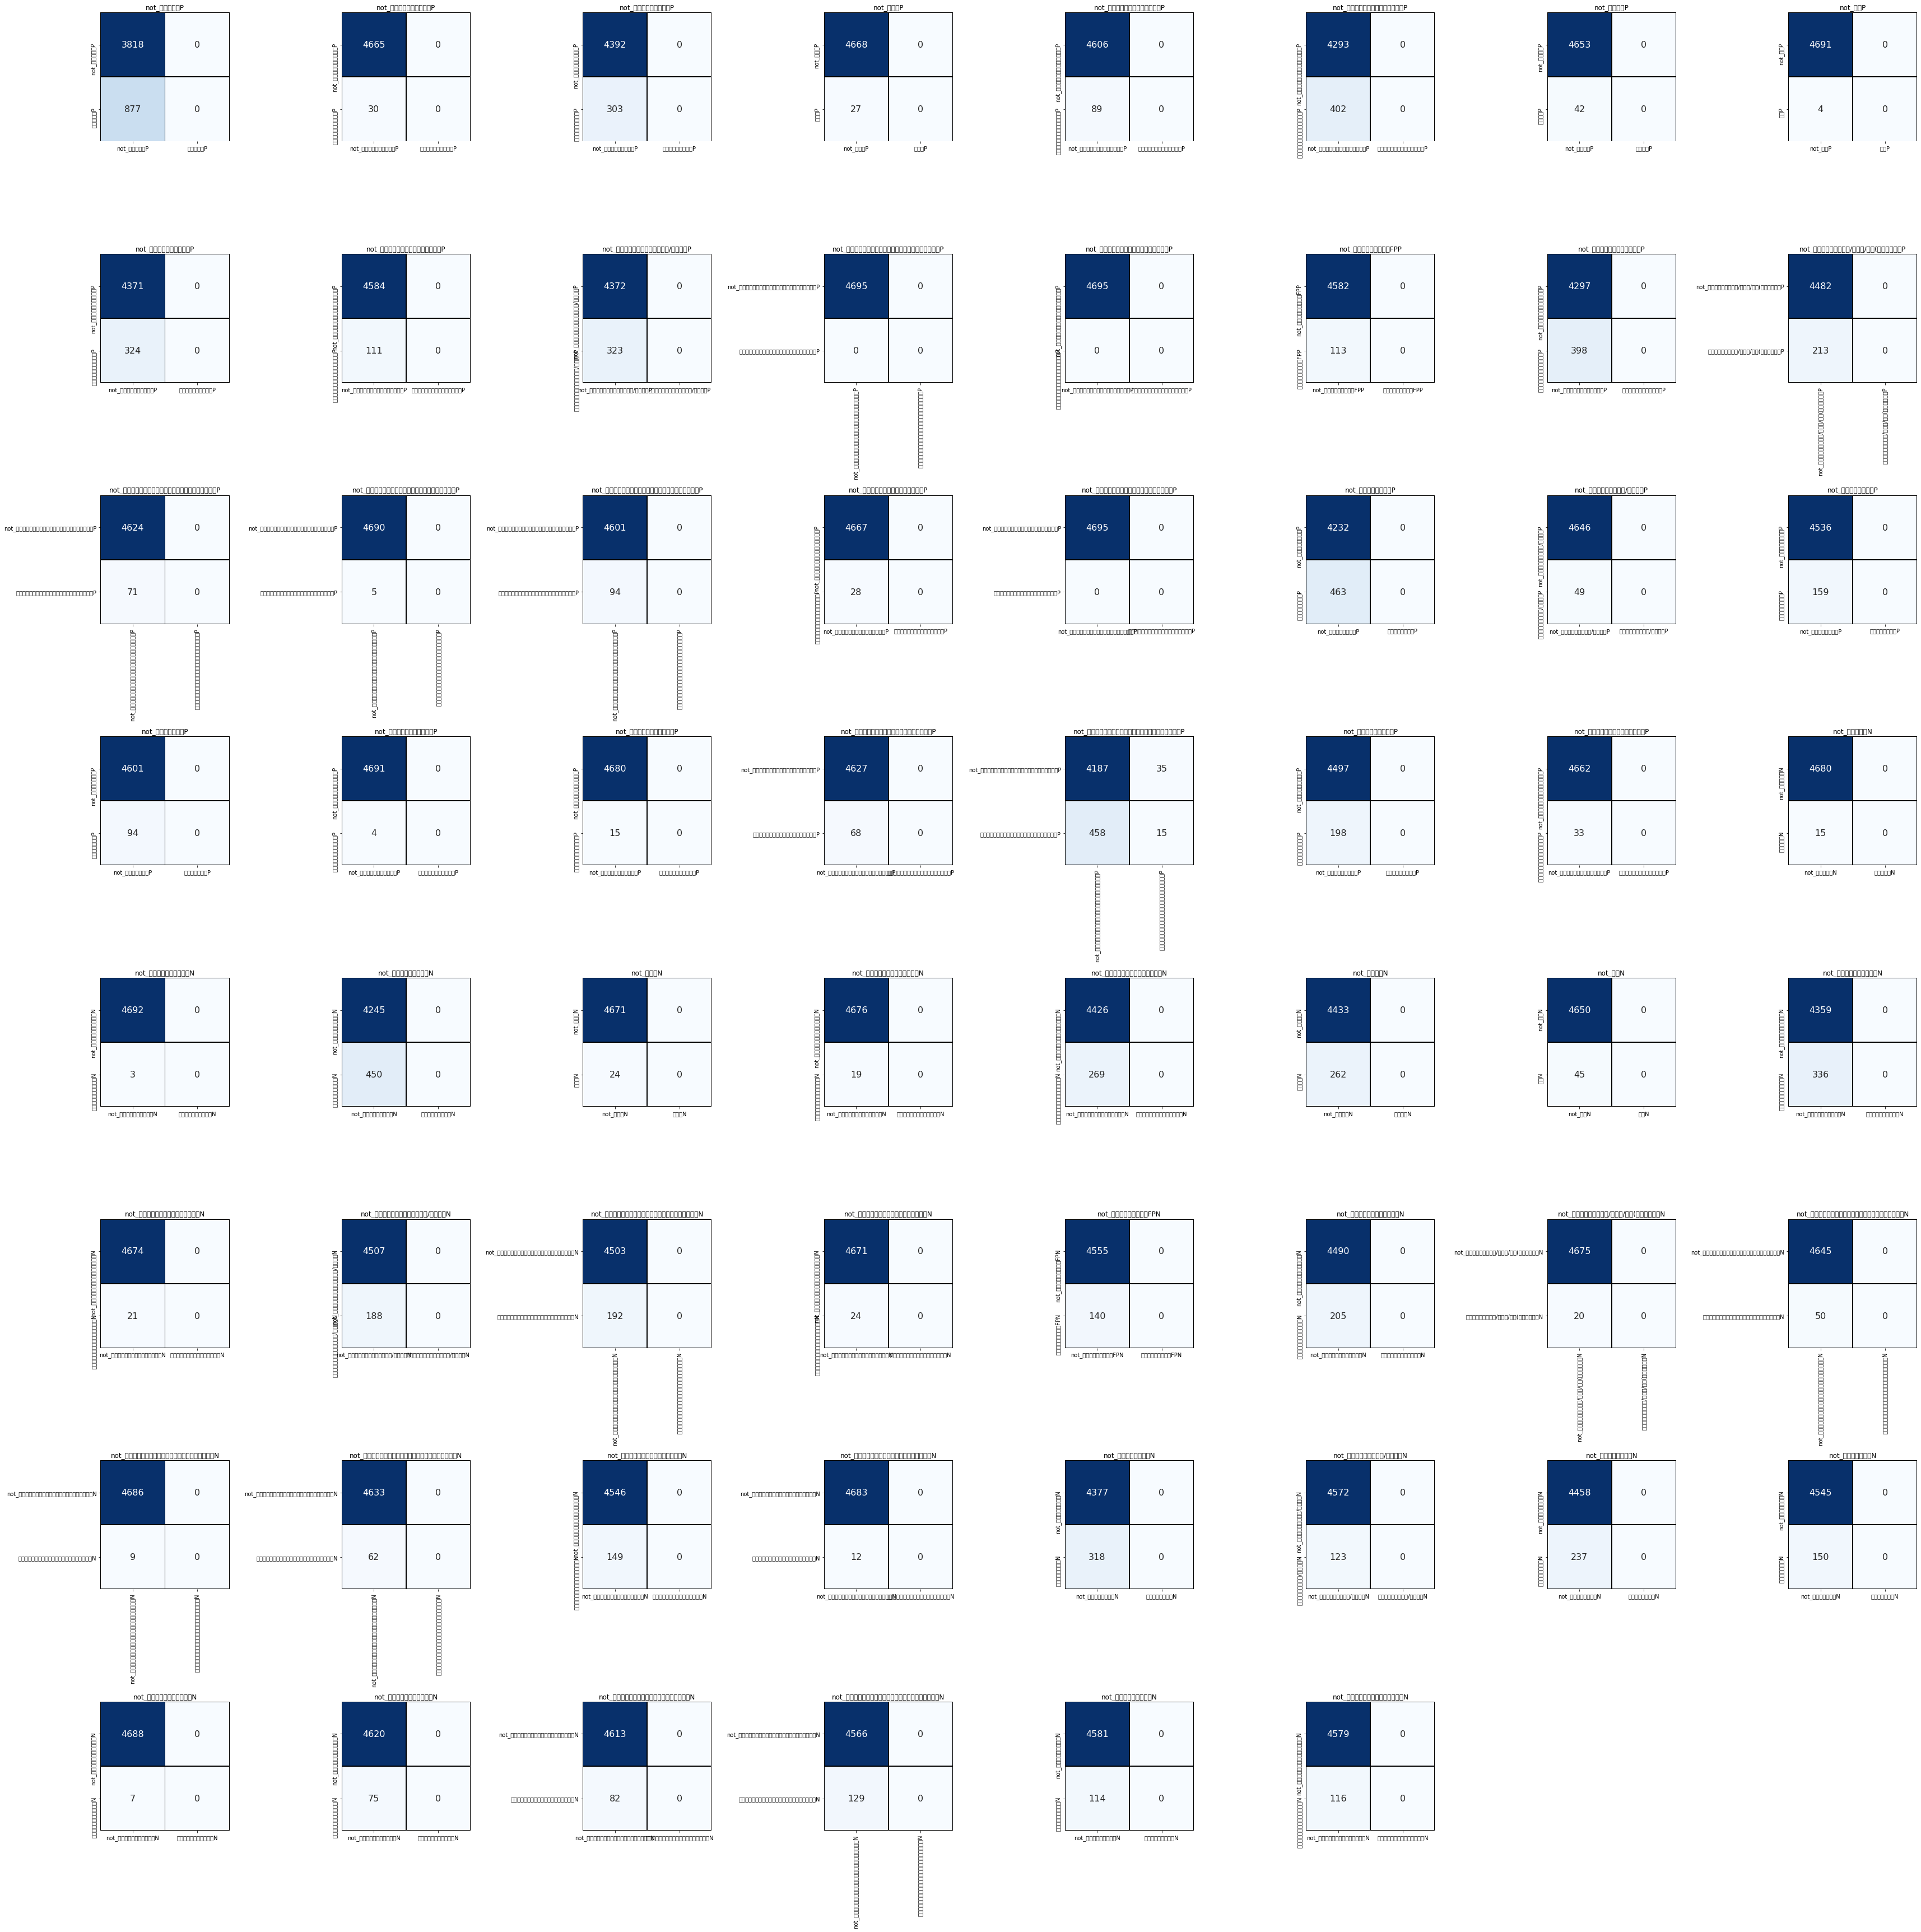

In [39]:
# Creating multilabel confusion matrix
confusion = multilabel_confusion_matrix(y_test, y_pred)

# Plot confusion matrix 
fig = plt.figure(figsize = (48, 48)) 
for i, (label, matrix) in enumerate(zip(Y_test.columns, confusion)):
    print("(label, matrix):", label, matrix)
    plt.subplot(8,8, i+1)
    labels = [f'not_{label}', label]
    sns.heatmap(matrix, annot = True, annot_kws={'size':16}, square = True, fmt = 'd', cbar = False, cmap = 'Blues', 
                xticklabels = labels, yticklabels = labels, linecolor = 'black', linewidth = 1)
    plt.title(labels[0])

plt.tight_layout()
plt.show()

In [40]:
# Hmmmm F-1 score is low, Lets see the distribution of class
Y_test.sum()/len(Y_test)

パーク全般P                      0.186794
園内全体の外観・装飾P                 0.006390
園内全体の混雑状況P                  0.064537
清潔感P                        0.005751
スペシャルイベント（装飾）P              0.018956
                              ...   
【レストルーム】その他N                0.015974
【キャスト】対応能力（迅速さ・正確さ）N        0.017465
【キャスト】態度・印象（笑顔・礼儀・話し方等）N    0.027476
【キャスト】その他N                  0.024281
【その他サービス施設】その他N             0.024707
Length: 62, dtype: float64

# 10. Wrapping into main function

In [41]:
def main():
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # build pipeline
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier()))      
    ])     
        
    # train classifier
    pipeline.fit(X_train, y_train)
    # predict on test data
    y_pred=pipeline.predict(X_test)
    # display results
    #display_results(y_test, y_pred)
